## 1 Problem 1 (10 pts)
**Theoretical Task**

It is often stated, that pure content-based recommendation models provide very low level of personalization to users.

Prove this claim using a standard regression-based formulation for the case when a single global model is learned in the form:
$$
r \approx \theta^{T} x+\epsilon
$$
where vector $x$ encodes some features of both users and items (e.g., user attributes and item characteristics), and $\theta$ are the corresponding learnable weights of the regression model. Recall that personalization task is formulated as the ranking problem of the top-$n$ best-matching items:
$$
\operatorname{toprec}(u, n)=\arg \max _{i}^{n} r_{u i}
$$
where $r_{u i}$ is the relevance score assigned by the model to item $i$ for user $u$.

$$\arg \max _{i}^{n} r_{u i} = \arg \max _{i}^{n} (\theta^{T} x + \epsilon)$$

Let's clarify what we have:

$\theta^T$ - some learnable weights for both user and item features represented like:


$$\theta^T = (\theta^T_{U}, \theta^T_{I})\text{, where $U$ stands for user and $I$ for item correspondigly.}$$

$r_{ui}$ - predicted rating of item $i$ for user $u$:

Thus, $r_{ui} \approx \theta^{T} x_{ui} + \epsilon = 
(\theta^T_{U}, \theta^T_{I}) \cdot 
\left(\begin{matrix}
    x_u \\
    y_i \\    
\end{matrix}\right) = b_u + \theta^T_{U}x_u + b_i + \theta^T_{I}y_i
$

According to our model our predictions for items $i$ and $j$ will be ranked as follows:

$\Rightarrow \Delta r = r_{ui} - r_{uj} = \underbrace{b_u - b_u}_0 + \underbrace{\theta^T_{U}x_u - \theta^T_{U}x_u}_0 + \underbrace{b_i - b_j}_0 + \theta^T_{I}y_i - \theta^T_{I}y_j =$

$= \theta^T_{I}(y_i - y_j)$

Well, now we can see, that our ranking approach doesn't really rely on user preferences.

## 2 Problem 2 (20 pts)
**Content-based models with personalization**

In this problem you will train simple content-based model for each user individually in order to achieve some level of personalization.
1. Build collection of CB models on the anime data from Lecture 2 ( you are free to use any content-based approach (regression- or similarity-based) you like) and perform a standard evaluation (using material from Lecture 3).

For evaluation you withhold one liked item from each of the test users (you can take the same users as were used in a simpler item-pair-based evaluation scheme in Lecture 2), and use the rest of the items from user history for training.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd

## Reading data

In [3]:
from dataproc import load_animes, load_profiles_reviews

In [4]:
dir_name = 'data/'

In [5]:
anime_path = f'{dir_name}animes.csv'
profiles_path = f'{dir_name}profiles.csv'
reviews_path = f'{dir_name}reviews.csv'

In [6]:
anime = load_animes(anime_path)
reviews, profiles = load_profiles_reviews(reviews_path, profiles_path)

In [7]:
anime.query('score <= 0')

,anime_id,title,synopsis,genre,members,ranked,score,synopsis_ok,soup


In [8]:
reviews.query('score <= 0')

,uid,profile,anime_id,text,score,scores,link,profile_idx
63039,6424,Jackimus,226,\n \n \n \n ...,0,"{'Overall': '0', 'Story': '0', 'Animation': '0...",https://myanimelist.net/reviews.php?id=6424,12220


In [9]:
reviews_ = reviews.query('score > 0')
reviews_.head(1)

,uid,profile,anime_id,text,score,scores,link,profile_idx
0,255938,DesolatePsyche,34096,\n \n \n \n ...,8,"{'Overall': '8', 'Story': '8', 'Animation': '8...",https://myanimelist.net/reviews.php?id=255938,6837


In [10]:
anime_ = anime[['anime_id', 'soup']]
anime_.head(3)

,anime_id,soup
0,28891,following participation inter high karasuno hi...
1,23273,music accompanies path human metronome prodigi...
2,34599,abyss gaping chasm stretching depths earth fil...


Filter active users(20+ scores):

In [11]:
users_ = reviews \
.loc[
    reviews \
    .groupby('profile_idx')['anime_id'] \
    .transform('count') > 60 \
]

users_ = users_[['profile_idx', 'anime_id', 'score']]
users_.head(3)

,profile_idx,anime_id,score
0,6837,34096,8
10,31705,4672,8
16,19694,30276,8


In [12]:
data = pd.merge(users_, anime_, 'inner', 'anime_id')
data.head(3)

,profile_idx,anime_id,score,soup
0,6837,34096,8,joining resistance bakufu gintoki gang hiding ...
1,11822,34096,7,joining resistance bakufu gintoki gang hiding ...
2,38867,34096,10,joining resistance bakufu gintoki gang hiding ...


In [13]:
users_.profile_idx.nunique()

109

In [14]:
data.profile_idx.nunique()

109

## Preparation for training

In [15]:
from utils import leave_last_out

In [16]:
training, holdout = leave_last_out(data, 'score')

In [17]:
training.head(3)

,profile_idx,anime_id,score,soup
0,431,1530,2,young child aizawa yuuichi often visited cousi...
1,431,853,3,haruhi fujioka bright scholarship candidate ra...
2,431,8475,3,asura unrelentingly dark drama follows struggl...


In [18]:
holdout.head(3)

,profile_idx,anime_id,score,soup
0,431,16774,10,jack knife edge town edgy sounds inferno cop s...
1,1002,35249,10,world much like great race horses past chance ...
2,1618,36864,10,despite incredible bashfulness atsuhiro akkun ...


## Similarity-based approach

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

from utils import get_user_profiles

In [22]:
sim_config = {
    'tfidf': dict(
        ngram_range = (2, 2),
        min_df=5, max_df=0.9,
        strip_accents='unicode',
        stop_words = 'english',
        analyzer = 'word',
        use_idf=1,
        smooth_idf=1,
        sublinear_tf=1
    )
}

In [23]:
vectorizer = TfidfVectorizer(**sim_config['tfidf'])

In [24]:
item_training = vectorizer.fit_transform(training['soup']).toarray()
item_training.shape

(12838, 61602)

In [25]:
item_holdout = vectorizer.transform(holdout['soup']).toarray()
item_holdout.shape

(109, 61602)

In [26]:
users_profiles = get_user_profiles(item_training, training, holdout)
users_profiles.shape

(109, 61602)

In [27]:
items_profiles = vectorizer.transform(anime_['soup']).toarray()
items_profiles.shape

(16216, 61602)

In [28]:
from sklearn.metrics.pairwise import cosine_similarity

In [29]:
sim_scores = cosine_similarity(users_profiles, items_profiles)
sim_scores.shape

(109, 16216)

## Evaluation

In [30]:
topn_grid = np.logspace(1, 2, 20, dtype=int)
topn_grid

array([ 10,  11,  12,  14,  16,  18,  20,  23,  26,  29,  33,  37,  42,
        48,  54,  61,  69,  78,  88, 100])

3. **Compare** your model with any two baselines from the list below. Report about the results.

Possible models: [Random recommendations, Popularity-based, PopularityBased with Baesian averaging, Baseline predictors]

## Random approach

In [31]:
from utils import build_random_model, random_model_scoring

In [32]:
rnd_params = build_random_model({'seed': 99}, training)
rnd_scores = random_model_scoring(rnd_params, None, holdout.profile_idx.nunique())

## Popularity-based approach

In [33]:
from utils import build_popularity_model, popularity_model_scoring

In [34]:
pop_params = build_popularity_model({}, training)
pop_scores = popularity_model_scoring(pop_params, None, holdout.profile_idx.nunique())

In [35]:
from utils import plot_metric

In [36]:
scores_list = [
    ('Cosine similarity', sim_scores),
    ('Random recom', rnd_scores),
    ('Pop recom', pop_scores)
]

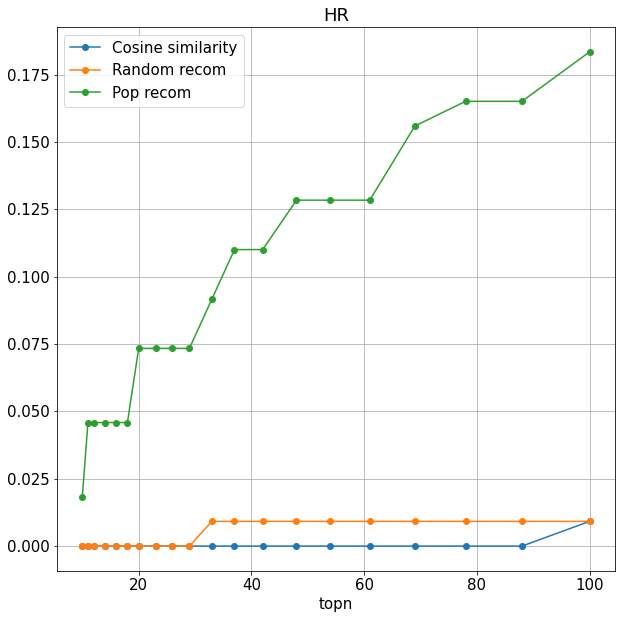

In [37]:
plot_metric('hr', topn_grid, scores_list, holdout, anime)

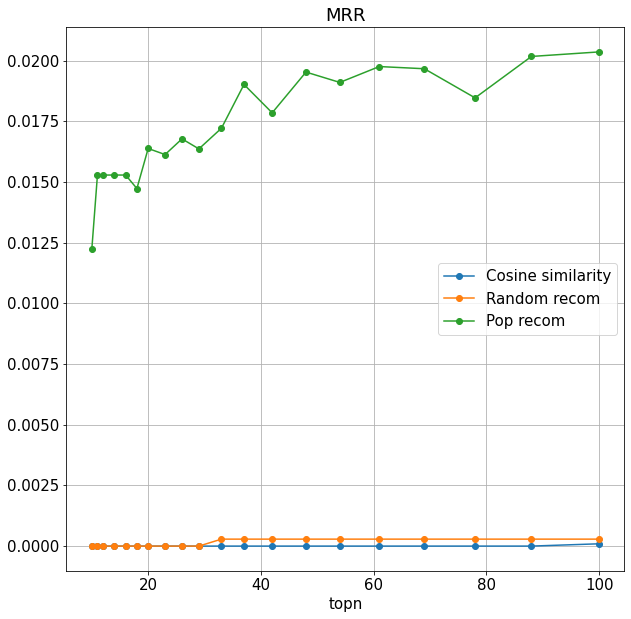

In [38]:
plot_metric('mrr', topn_grid, scores_list, holdout, anime)

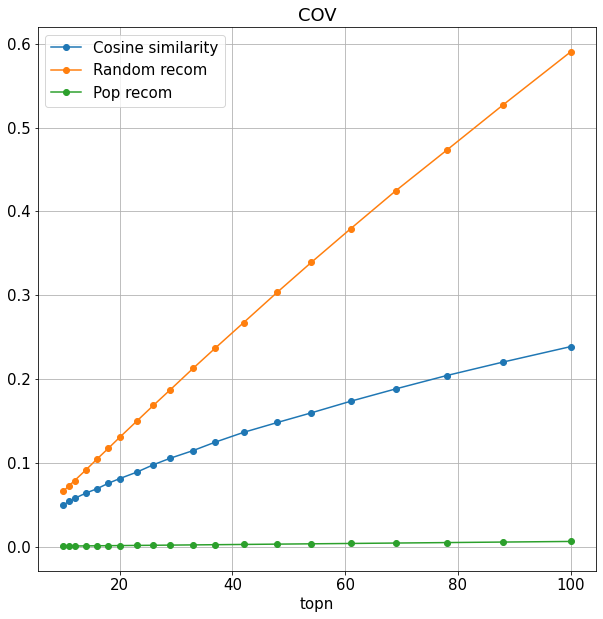

In [39]:
plot_metric('cov', topn_grid, scores_list, holdout, anime)

## Summary

Thus, popularity-based gives best **MRR** and **HR** scores, while random recommendations considered the most diverse, although cosine similarity performs not that bad in terms of diversity.

## 3 Problem 3 (20 pts)
**SVD models**

Implement the normalized version of the PureSVD model and compare it to standard PureSVD. Recall that normalization is based on a scheme:
$$
\boldsymbol{A} \boldsymbol{D}^{f-1}
$$
where $f$ is a hyperparameter of the model that needs to be empirically found. $\boldsymbol{A} \in \mathbb{R}^{M \times N}$ is the original matrix of user-item interactions between $M$ users and $N$ items, and $\boldsymbol{D} \in \mathbb{R}^{N \times N}$ is a diagonal matrix of normalization weights obtained as norms of the corresponding rows of $A$, i.e. $[\boldsymbol{D}]_{i i}=\left\|\boldsymbol{a}_{i}\right\|_{2}$.

Both models must be tuned using random gridsearch strategy. Use Moveilens dataset for your experiments. Split validation data from the training for tuning your models
1. Peform gridsearch on a set of rank values from range $[20,200]$ and a set of values of $f$ from $[-1,0)$.
2. Use MRR@10 metric as the target for finding the optimal model and also report HR@n and Coverage@n metrics in the final evaluation.
3. Use simple leave-last-out scheme based on timestamps.

Once the optimal configuration of a model is found retrain it on the joint train+validation dataset and finally evaluate it against the test data.

In [40]:
from polara import get_movielens_data
from polara.preprocessing.dataframes import leave_one_out, reindex

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, LinearOperator

from dataprep import transform_indices

In [41]:
data = get_movielens_data(include_time=True)

In [42]:
training_, holdout_ = leave_one_out(data, target='timestamp', sample_top=True, random_state=0)

assert holdout_.set_index('userid')['timestamp'].ge(
    training_
    .groupby('userid')
    ['timestamp'].max()
).all()

In [43]:
training, data_index = transform_indices(training_, 'userid', 'movieid')
holdout = reindex(holdout_, data_index.values(), filter_invalid=True)
holdout = holdout.sort_values('userid')

Filtered 2 invalid observations.


In [44]:
holdout.head(3)

,userid,movieid,rating,timestamp
25,0,47,5,978824351
87,1,1420,4,978300174
232,2,1900,4,978298504


In [87]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)

## PureSVD

In [88]:
def matrix_from_observations(data, data_description):
    useridx = data[data_description['users']]
    itemidx = data[data_description['items']]
    values = data[data_description['feedback']]
    return csr_matrix((values, (useridx, itemidx)), dtype='f8')

def build_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    _, s, vt = svds(source_matrix, k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values

In [89]:
svd_config = {'rank': 200}

V, sigma = svd_params = build_svd_model(svd_config, training, data_description)

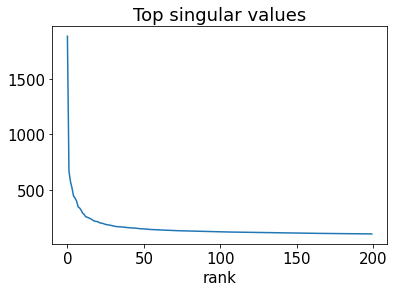

In [90]:
pd.Series(sigma).plot(title='Top singular values', xlabel='rank');

## Evaluation

In [91]:
def svd_model_scoring(params, data, data_description):
    item_factors, sigma = params
    train_matrix = data_description['train_matrix']
    test_users = data_description['test_users']
    test_matrix = train_matrix[test_users, :]
    scores = test_matrix.dot(item_factors) @ item_factors.T
    return scores

In [92]:
train_matrix = matrix_from_observations(training, data_description)

In [93]:
data_description['train_matrix'] = train_matrix
test_users = holdout[data_description['users']].drop_duplicates().values
data_description['test_users'] = test_users

In [94]:
svd_scores = svd_model_scoring(svd_params, None, data_description)

In [95]:
from utils import simple_model_recom_func

In [96]:
svd_rec = simple_model_recom_func(svd_scores, topn=10)

In [116]:
def model_evaluate(recommended_items, holdout, data, topn=10):
    holdout_items = holdout.movieid.values
    assert recommended_items.shape[0] == len(holdout)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / len(hits_mask)
    
    # coverage calculation
    coverage = len(np.unique(recommended_items)) / data.movieid.nunique()
    
    return round(hr, 4), round(mrr, 4), round(coverage, 4)

In [117]:
model_evaluate(svd_rec, holdout, data, topn=10)

(0.0033, 0.0004, 0.1846)

## Normalized SVD

In [118]:
from scipy.sparse import diags
import numpy.linalg as nla

from scipy.sparse.linalg import svds

In [119]:
train_matrix = training[['userid', 'movieid', 'rating']].pivot_table(index='userid', columns='movieid', aggfunc=np.sum, fill_value=0, values='rating')
train_matrix.head(3)

movieid,0,1,2,3,4,5,6,7,8,9,...,3694,3695,3696,3697,3698,3699,3700,3701,3702,3703
userid,,,,,,,,,,,,,,,,,,,,,
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
def build_normed_svd_model(config, data, data_description):
    source_matrix = matrix_from_observations(data, data_description)
    _, s, vt = svds(source_matrix.dot(config['norm']), k=config['rank'], return_singular_vectors='vh')
    singular_values = s[::-1]
    item_factors = np.ascontiguousarray(vt[::-1, :].T)
    return item_factors, singular_values

## GridSearch

In [121]:
from tqdm import tqdm

In [122]:
svd_config = {}

top_mrr = 0.
top_rank = -1
top_f = 10

for rank in [20, 200]:
    
    svd_config['rank'] = rank
    
    for f in tqdm(np.linspace(-1, 0, 20)):
    
        svd_config['norm'] = diags([nla.norm(train_matrix.values, ord=2, axis=0, keepdims=False) ** (f - 1.0)], [0])

        V, sigma = svd_params = build_svd_model(svd_config, training, data_description)

        svd_scores = svd_model_scoring(svd_params, None, data_description)
        norm_svd_rec = simple_model_recom_func(svd_scores, topn=10)
        mrr_val = model_evaluate(norm_svd_rec, holdout, data, topn=10)[1]

        if mrr_val > top_mrr:
            top_mrr = mrr_val
            top_rank = rank
            top_f = f
            
top_mrr, top_rank, top_f

100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


(0.0067, 20, -1.0)

In [123]:
svd_config = {'rank': top_rank, 'f': top_f}

In [124]:
svd_config['norm'] = diags([nla.norm(train_matrix.values, ord=2, axis=0, keepdims=False) ** (svd_config['f'] - 1.0)], [0])

In [125]:
V, sigma = svd_params = build_svd_model(svd_config, training, data_description)

best_svd_scores = svd_model_scoring(svd_params, None, data_description)
best_svd_rec = simple_model_recom_func(best_svd_scores, topn=10)

In [137]:
print('Pure SVD:\n')

print('HR \t MRR \t coverage')

print(*model_evaluate(svd_rec, holdout, data, topn=10), sep='\t')

Pure SVD:

HR 	 MRR 	 coverage
0.0033	0.0004	0.1846


In [138]:
print('Normalised SVD:\n')

print('HR \t MRR \t coverage')

print(*model_evaluate(best_svd_rec, holdout, data, topn=10), sep='\t')

Normalised SVD:

HR 	 MRR 	 coverage
0.0257	0.0067	0.102


## Summary

Thus, we achieved our desired **MRR** score as a result of normalised SVD application